In [10]:
!pip install jupyter-resource-usage

In [2]:
import pandas as pd
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of rows and columns
num_rows = 15000
num_cols = 10

# Create a time range for the timestamps (every 2 seconds)
time_range = pd.date_range(start='2025-01-01 00:00:00', periods=num_rows, freq='2S')

# Generate simulated data for each column
data = {
    'timestamp': time_range,
    'temp_motor': np.linspace(25, 75, num_rows) + np.random.normal(0, 1, num_rows),
    'power_in': np.linspace(500, 1500, num_rows) + np.random.normal(0, 5, num_rows),
    'speed_rpm': np.linspace(1000, 5000, num_rows) + np.random.normal(0, 10, num_rows),
    'torque_nm': np.linspace(10, 30, num_rows) + np.random.normal(0, 0.5, num_rows),
    'voltage': np.full(num_rows, 480) + np.random.normal(0, 0.2, num_rows),
    'current': np.linspace(1.5, 3.5, num_rows) + np.random.normal(0, 0.1, num_rows),
    'sensor_1': np.random.rand(num_rows) * 10,
    'sensor_2': np.random.rand(num_rows) * 5,
    'status_code': np.random.choice([1, 2, 3, 4], size=num_rows, p=[0.7, 0.1, 0.1, 0.1])
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('motor_test_sample.csv', index=False)

print("Sample file 'motor_test_sample.csv' created successfully.")

C:\Users\jforr\AppData\Local\Temp\ipykernel_21168\2441590741.py:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(start='2025-01-01 00:00:00', periods=num_rows, freq='2S')


Sample file 'motor_test_sample.csv' created successfully.


Embedding file 'motor_test_embeddings.csv' created successfully.


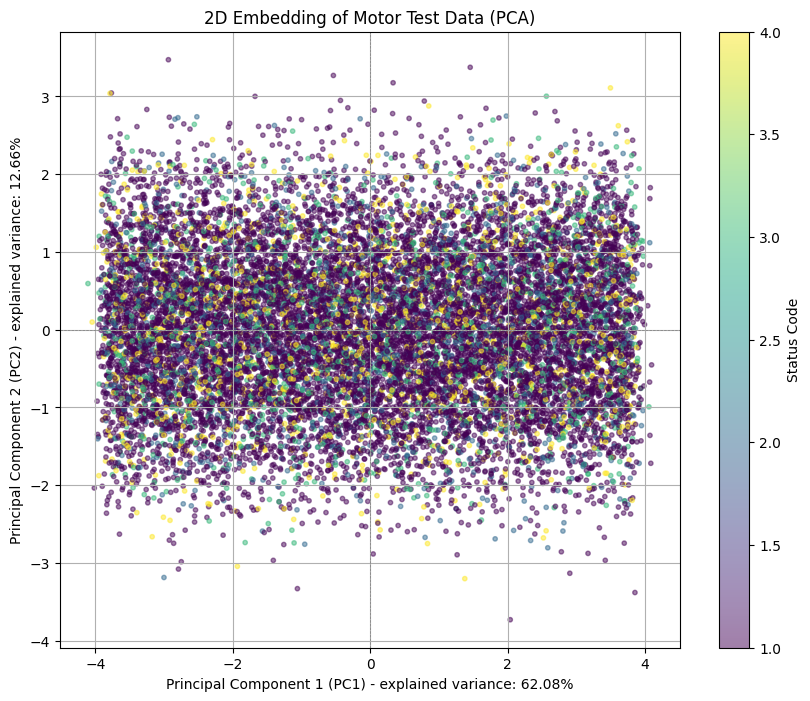

Plot 'pca_quadrant_plot.png' saved successfully.


<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the previously created sample data
df = pd.read_csv('motor_test_sample.csv')

# --- Step 1: Data Preprocessing ---
# Select the numerical columns for creating the embedding.
# We exclude 'timestamp' and 'status_code' for this example.
numeric_cols = ['temp_motor', 'power_in', 'speed_rpm', 'torque_nm',
                'voltage', 'current', 'sensor_1', 'sensor_2']
df_numeric = df[numeric_cols]

# Standardize the data. This is a crucial step before PCA.
# It ensures all features contribute equally to the principal components.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# --- Step 2: Create Embeddings using PCA ---
# The user's request for "quadrant" evaluation implies a 2D representation.
# We'll use PCA to reduce the 8 numerical features into 2 principal components.
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame for the embeddings
embeddings_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# --- Step 3: Store the Embeddings in a File ---
# We'll also add the original 'status_code' column for visualization later.
embeddings_df['status_code'] = df['status_code']
embeddings_df.to_csv('motor_test_embeddings.csv', index=False)

print("Embedding file 'motor_test_embeddings.csv' created successfully.")

# --- Step 4: Visualize for "Quadrant" Evaluation ---
# Create a scatter plot of the principal components.
# This visualizes the data points in a 2D space, effectively creating "quadrants".
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_df['PC1'], embeddings_df['PC2'],
                      c=embeddings_df['status_code'], cmap='viridis', s=10, alpha=0.5)

# Create a color bar with labels for the status codes
cbar = plt.colorbar(scatter)
cbar.set_label('Status Code')

plt.title('2D Embedding of Motor Test Data (PCA)')
plt.xlabel(f'Principal Component 1 (PC1) - explained variance: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'Principal Component 2 (PC2) - explained variance: {pca.explained_variance_ratio_[1]:.2%}')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()

# Save the plot
plt.savefig('pca_quadrant_plot.png')
print("Plot 'pca_quadrant_plot.png' saved successfully.")

In [4]:
from qdrant_client import QdrantClient, models

# Initialize Qdrant client in memory for simplicity
client = QdrantClient(":memory:")

In [5]:
# The name of our collection
collection_name = "motor_test_runs"

# Check if the collection already exists and delete it if so
try:
    client.delete_collection(collection_name=collection_name)
except Exception:
    pass

# Create a new collection with the correct vector size and distance metric
client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(size=2, distance=models.Distance.EUCLID),
)

print(f"Collection '{collection_name}' created successfully.")

Collection 'motor_test_runs' created successfully.


In [6]:
# Load the embeddings file created earlier
embeddings_df = pd.read_csv('motor_test_embeddings.csv')

# Prepare the data for upload
points = [
    models.PointStruct(
        id=idx,
        vector=row[['PC1', 'PC2']].values.tolist(),
        payload={"status_code": int(row['status_code'])}
    )
    for idx, row in embeddings_df.iterrows()
]

# Upload the points to the collection
client.upsert(
    collection_name=collection_name,
    points=points,
)

print(f"Successfully uploaded {len(points)} points to the collection.")

Successfully uploaded 15000 points to the collection.


In [7]:
# Select a random data point to use as a query
query_point = embeddings_df.sample(n=1, random_state=42)
query_vector = query_point[['PC1', 'PC2']].values.tolist()[0]
query_id = query_point.index[0]

# Perform a search for the 5 most similar points
search_results = client.search(
    collection_name=collection_name,
    query_vector=query_vector,
    limit=5,
    with_payload=True
)

print(f"\nSearching for points similar to point ID {query_id}:\n")
for result in search_results:
    print(f"ID: {result.id}, "
          f"Score: {result.score:.4f}, "
          f"Vector: [{result.vector[0]:.2f}, {result.vector[1]:.2f}], "
          f"Status: {result.payload['status_code']}")


Searching for points similar to point ID 11499:



C:\Users\jforr\AppData\Local\Temp\ipykernel_21168\3666703403.py:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


TypeError: 'NoneType' object is not subscriptable

Autoencoder model trained successfully.
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder embedding file 'autoencoder_embeddings.csv' created successfully.


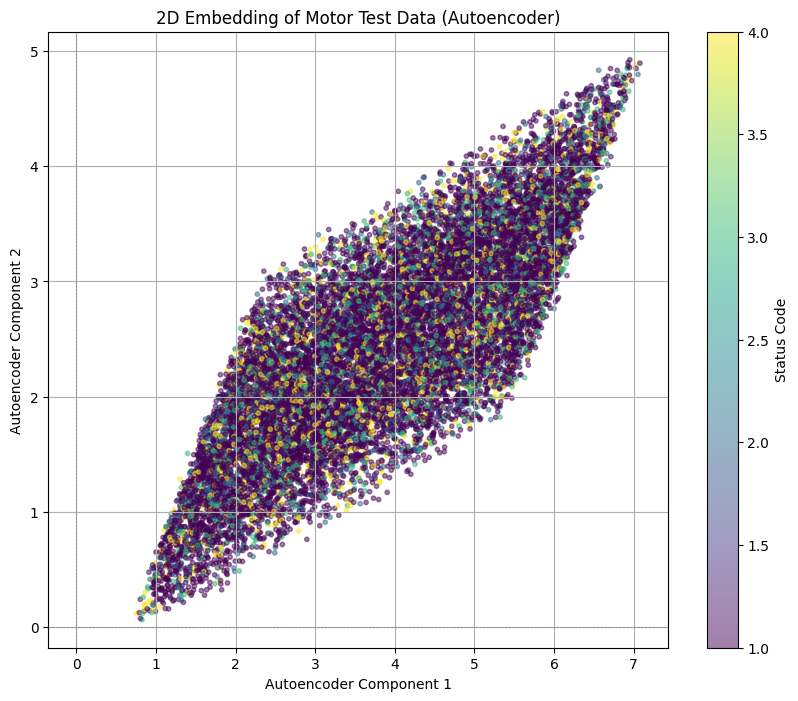

Plot 'autoencoder_quadrant_plot.png' saved successfully.


<Figure size 640x480 with 0 Axes>

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Load the previously created sample data
df = pd.read_csv('motor_test_sample.csv')

# --- Step 1: Data Preprocessing ---
# Select the numerical columns for the autoencoder.
numeric_cols = ['temp_motor', 'power_in', 'speed_rpm', 'torque_nm',
                'voltage', 'current', 'sensor_1', 'sensor_2']
X = df[numeric_cols]

# Standardize the data. This is crucial for neural networks.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: Define and Train the Autoencoder Model ---

# Define the input dimension
input_dim = X_scaled.shape[1]
# Define the size of the embedding (we'll keep it at 2D for visualization)
embedding_dim = 2

# Encoder layers (the "compression" part)
input_layer = Input(shape=(input_dim,))
encoded = Dense(6, activation='relu')(input_layer)  # First hidden layer
encoded = Dense(4, activation='relu')(encoded)      # Second hidden layer
embedding = Dense(embedding_dim, activation='relu', name='encoder_output')(encoded) # The embedding layer

# Decoder layers (the "reconstruction" part)
decoded = Dense(4, activation='relu')(embedding)
decoded = Dense(6, activation='relu')(decoded)
# The final layer must have a linear activation to output un-bounded scaled values
output_layer = Dense(input_dim, activation='linear')(decoded)

# Create the full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Mean Squared Error (MSE) loss, which is perfect for this task
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
# The input and target are the same since we're teaching the model to reconstruct its input
autoencoder.fit(X_scaled, X_scaled,
                epochs=50,       # Number of passes through the data
                batch_size=32,   # Number of samples per gradient update
                shuffle=True,    # Shuffles data for better learning
                verbose=0)       # Suppress training output for a cleaner console
print("Autoencoder model trained successfully.")


# --- Step 3: Extract the Embeddings ---
# Create a new model that is just the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=embedding)

# Use the encoder model to generate the embeddings for all your data
autoencoder_embeddings = encoder_model.predict(X_scaled)

# Create a DataFrame for the new embeddings
embeddings_df = pd.DataFrame(autoencoder_embeddings, columns=['AE_1', 'AE_2'])
embeddings_df['status_code'] = df['status_code']

# Save the embeddings to a new CSV file
embeddings_df.to_csv('autoencoder_embeddings.csv', index=False)
print("Autoencoder embedding file 'autoencoder_embeddings.csv' created successfully.")


# --- Step 4: Visualize the Embeddings ---
# Plot the embeddings to visually evaluate the "quadrants"
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_df['AE_1'], embeddings_df['AE_2'],
                      c=embeddings_df['status_code'], cmap='viridis', s=10, alpha=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Status Code')

plt.title('2D Embedding of Motor Test Data (Autoencoder)')
plt.xlabel('Autoencoder Component 1')
plt.ylabel('Autoencoder Component 2')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()

# Save the plot
plt.savefig('autoencoder_quadrant_plot.png')
print("Plot 'autoencoder_quadrant_plot.png' saved successfully.")

In [9]:
import pandas as pd

# Load the sample data (assuming it's in a DataFrame 'df')
df = pd.read_csv('motor_test_sample.csv')

# Calculate the difference between consecutive temperature readings
df['temp_change'] = df['temp_motor'].diff()

# Since the measurements are every 2 seconds, we divide by 2 to get the rate of change per second
df['temp_rate_of_change'] = df['temp_change'] / 2

# You can now drop the intermediate 'temp_change' column if you want
df = df.drop(columns=['temp_change'])

# Display the first few rows to show the new feature
print(df[['timestamp', 'temp_motor', 'temp_rate_of_change']].head())

             timestamp  temp_motor  temp_rate_of_change
0  2025-01-01 00:00:00   25.496714                  NaN
1  2025-01-01 00:00:02   24.865069            -0.315822
2  2025-01-01 00:00:04   25.654356             0.394643
3  2025-01-01 00:00:06   26.533031             0.439337
4  2025-01-01 00:00:08   24.779181            -0.876925


In [11]:
import pandas as pd
import numpy as np

# --- Step 1: Define the chunking function ---
def create_time_chunks(df, window_size, step_size):
    """
    Splits a DataFrame into a list of smaller DataFrames (time chunks) using a sliding window.

    Args:
        df (pd.DataFrame): The input DataFrame.
        window_size (int): The number of rows in each chunk.
        step_size (int): The number of rows to slide the window at each step.

    Returns:
        list: A list of DataFrame chunks.
    """
    chunks = []
    num_rows = len(df)
    # The loop iterates through the DataFrame, creating a slice for each chunk
    for i in range(0, num_rows - window_size + 1, step_size):
        chunk = df.iloc[i : i + window_size]
        chunks.append(chunk)
    return chunks

# --- Step 2: Define the embedding function for each chunk ---
def create_chunk_embedding(chunk):
    """
    Creates an embedding vector for a single time chunk using statistical summaries.
    This method captures key aspects of the data (central tendency, spread, range).

    Args:
        chunk (pd.DataFrame): The input time chunk.

    Returns:
        np.array: A 1D numpy array representing the chunk's embedding.
    """
    # Select only the numeric columns for the embedding
    numeric_cols = ['temp_motor', 'power_in', 'speed_rpm', 'torque_nm',
                    'voltage', 'current', 'sensor_1', 'sensor_2']
    chunk_numeric = chunk[numeric_cols]

    # Calculate summary statistics for each column in the chunk
    mean_vector = chunk_numeric.mean().values
    std_vector = chunk_numeric.std().values
    min_vector = chunk_numeric.min().values
    max_vector = chunk_numeric.max().values

    # Concatenate all summary statistics to form a single, rich embedding vector
    embedding = np.concatenate([mean_vector, std_vector, min_vector, max_vector])

    return embedding

# --- Main execution block ---

# Load the previously created sample data
# Assuming 'motor_test_sample.csv' has been generated in a prior step.
df = pd.read_csv('motor_test_sample.csv')

# Set parameters for chunking the test data
window_size = 300  # 300 rows is equivalent to 10 minutes (300 * 2 seconds / 60)
step_size = 30     # Slide the window by 30 rows, or 1 minute, at each step

# Split the single test run into time chunks
test_chunks = create_time_chunks(df, window_size, step_size)
print(f"Total number of chunks created: {len(test_chunks)}")

# Generate embeddings for each chunk
chunk_embeddings = [create_chunk_embedding(chunk) for chunk in test_chunks]

# Create a DataFrame from the embeddings
# Each row in this new DataFrame is a vector representing a time chunk
embeddings_df = pd.DataFrame(chunk_embeddings)

# Store the embeddings in a CSV file
embeddings_df.to_csv('chunk_embeddings.csv', index=False)
print("Successfully generated and saved chunk embeddings to 'chunk_embeddings.csv'.")

Total number of chunks created: 491
Successfully generated and saved chunk embeddings to 'chunk_embeddings.csv'.
